This approach uses an advanced text mining method, word-embedding.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline 

Root Mean Squared Logarithmic Error (RMSLE) as the evaluation metrics

In [2]:
def rmsle(y, y_pred):
    """
    A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
    """
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5
#Source: https://www.kaggle.com/marknagelberg/rmsle-function

Load the dataset

In [3]:
data = pd.read_table("train.tsv")
print(data.shape)

(100001, 8)


## Data Preprocessing
- Log-transfer and normalize price

Text(0.5,0,'Target (Log-transformed and normalized Price)')

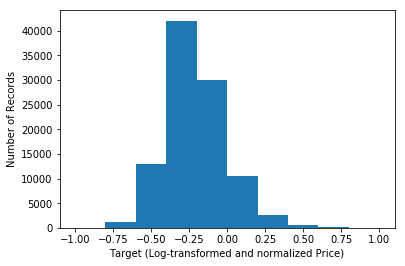

In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler

data['target'] = np.log(data['price']+1)
target_scaler = MinMaxScaler(feature_range=(-1, 1))
data["target"] = target_scaler.fit_transform(data.target.values.reshape(-1,1))

plt.hist(data['target'], normed=False, bins=10)
plt.ylabel('Number of Records')
plt.xlabel('Target (Log-transformed and normalized Price)')

- Handle missing data;
- Cut number of brand names and number of categories;
- Transfer category_name, brand_name, and item_condition_id to categorical data

In [5]:
NUM_BRANDS = 1000
NUM_CATEGORIES = 500

def handle_missing_inplace(dataset):
    dataset['category_name'].fillna(value='missing', inplace=True)
    dataset['brand_name'].fillna(value='missing', inplace=True)
    dataset['item_description'].fillna(value='missing', inplace=True)

def cutting(dataset):
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['category_name'].isin(pop_category), 'category_name'] = 'missing'


def to_categorical(dataset):
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

handle_missing_inplace(data)
print('Finished to handle missing')

cutting(data)
print('Finished to cut')

to_categorical(data)
print('Finished to convert categorical')

Finished to handle missing
Finished to cut
Finished to convert categorical


Process categorical data

In [6]:
le = LabelEncoder()
le.fit(data.category_name)
data.category_name = le.transform(data.category_name)
le.fit(data.brand_name)
data.brand_name = le.transform(data.brand_name)
le.fit(data.item_condition_id)
data.item_condition_id = le.transform(data.item_condition_id)
del le

In [7]:
display(data.head(n=3))

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,target
0,100000,3 piece crop top/halter set,2,941,314,19.0,0,All size small,-0.206939
1,100001,Fitbit Alta Bundle for Nathalia Lopez,0,655,330,12.0,0,Fitbit Alta replacement bands - 5 colors for N...,-0.320980
2,100002,iPad Gen 2 / Verizon,3,85,60,56.0,0,iPad Gen 2 with Verizon cell abilities. The wi...,0.070318


Process text

In [8]:
from keras.preprocessing.text import Tokenizer
raw_text = np.hstack([data.item_description.str.lower(), data.name.str.lower()])
tok_raw = Tokenizer()
tok_raw.fit_on_texts(raw_text)
data["seq_item_description"] = tok_raw.texts_to_sequences(data.item_description.str.lower())
data["seq_name"] = tok_raw.texts_to_sequences(data.name.str.lower())
display(data.head(n=2))

C:\Users\zhipe\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,target,seq_item_description,seq_name
0,100000,3 piece crop top/halter set,2,941,314,19.0,0,All size small,-0.206939,"[34, 6, 44]","[32, 265, 491, 62, 1013, 74]"
1,100001,Fitbit Alta Bundle for Nathalia Lopez,0,655,330,12.0,0,Fitbit Alta replacement bands - 5 colors for N...,-0.320980,"[1476, 3787, 1668, 1851, 36, 172, 3, 23369, 8332]","[1476, 3787, 27, 3, 23369, 8332]"


Show item_description_length

Maximun length of item description is   259
Minimun length of item description is     0
Maximum length of name is    11
Minimum length of name is     0


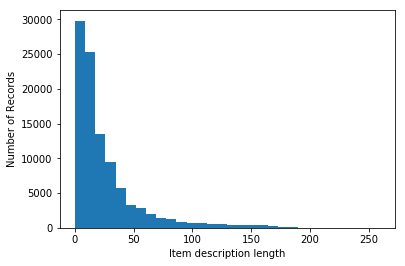

In [9]:
data['item_description_length'] = data.seq_item_description.str.len()
plt.hist(data['item_description_length'], normed=False, bins=30)
plt.ylabel('Number of Records');
plt.xlabel('Item description length')

print("Maximun length of item description is {0:5d}".format(data.item_description_length.max()))
print("Minimun length of item description is {0:5d}".format(data.item_description_length.min()))

data['name_length'] = data.seq_name.str.len()
print("Maximum length of name is {0:5d}".format(data.name_length.max()))
print("Minimum length of name is {0:5d}".format(data.name_length.min()))

- EMBEDDINGS MAX VALUE
- Base on the histograms, we select the next lengths

In [10]:
MAX_NAME_SEQ = 10
MAX_ITEM_DESC_SEQ = 75
MAX_TEXT = np.max([np.max(data.seq_name.max())
                  , np.max(data.seq_item_description.max())])+2
MAX_CATEGORY = data.category_name.max()+1
MAX_BRAND = data.brand_name.max()+1
MAX_CONDITION = data.item_condition_id.max()+1

Divid data

In [11]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(data, random_state=99, test_size=0.1)
dtrain, dvalid = train_test_split(train, random_state=99, test_size=0.01)
print(dtrain.shape)
print(dvalid.shape)

(89100, 13)
(900, 13)


## Deep learning

KERAS DATA DEFINITION

In [12]:

from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'name': pad_sequences(dataset.seq_name, maxlen=MAX_NAME_SEQ)
        ,'item_desc': pad_sequences(dataset.seq_item_description, maxlen=MAX_ITEM_DESC_SEQ)
        ,'brand_name': np.array(dataset.brand_name)
        ,'category_name': np.array(dataset.category_name)
        ,'item_condition': np.array(dataset.item_condition_id)
        ,'num_vars': np.array(dataset[["shipping"]])
    }
    return X

X_train = get_keras_data(dtrain)
X_valid = get_keras_data(dvalid)
X_test = get_keras_data(test)

-Define Keras model

In [13]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, GRU,LSTM, Embedding, Flatten, BatchNormalization
from keras.models import Model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras import backend as K

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

def rmsle_cust(y_true, y_pred):
    first_log = K.log(K.clip(y_pred, K.epsilon(), None) + 1.)
    second_log = K.log(K.clip(y_true, K.epsilon(), None) + 1.)
    return K.sqrt(K.mean(K.square(first_log - second_log), axis=-1))

def get_model():
    #params
    dr_r = 0.1
    
    #Inputs
    name = Input(shape=[X_train["name"].shape[1]], name="name")
    item_desc = Input(shape=[X_train["item_desc"].shape[1]], name="item_desc")
    brand_name = Input(shape=[1], name="brand_name")
    category_name = Input(shape=[1], name="category_name")
    item_condition = Input(shape=[1], name="item_condition")
    num_vars = Input(shape=[X_train["num_vars"].shape[1]], name="num_vars")
    
    #Embeddings layers
    emb_name = Embedding(MAX_TEXT, 50)(name)
    emb_item_desc = Embedding(MAX_TEXT, 50)(item_desc)
    emb_brand_name = Embedding(MAX_BRAND, 10)(brand_name)
    emb_category_name = Embedding(MAX_CATEGORY, 10)(category_name)
    emb_item_condition = Embedding(MAX_CONDITION, 5)(item_condition)
    
    #rnn layer
    rnn_layer1 = LSTM(16) (emb_item_desc)
    rnn_layer2 = LSTM(8) (emb_name)
    
    #main layer
    main_l = concatenate([
        Flatten() (emb_brand_name)
        , Flatten() (emb_category_name)
        , Flatten() (emb_item_condition)
        , rnn_layer1
        , rnn_layer2
        , num_vars
    ])
    main_l = Dropout(dr_r) (Dense(128) (main_l))
    main_l = Dropout(dr_r) (Dense(64) (main_l))
    
    #output
    output = Dense(1, activation="linear") (main_l)
    
    #model
    model = Model([name, item_desc, brand_name
                   , category_name, item_condition, num_vars], output)
    model.compile(loss="mse", optimizer="adam", metrics=["mae", rmsle_cust])
    
    return model

    
model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
brand_name (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
item_condition (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
item_desc (InputLayer)          (None, 75)           0                                            
__________________________________________________________________________________________________
name (Inpu

FITTING THE MODEL

In [14]:
BATCH_SIZE = 5000
epochs = 5

model.fit(X_train, dtrain.target, epochs=epochs, batch_size=BATCH_SIZE
          , validation_data=(X_valid, dvalid.target)
          , verbose=1)

Train on 89100 samples, validate on 900 samples
Epoch 1/5
89100/89100 [==============================] - 10s 114us/step - loss: 0.0513 - mean_absolute_error: 0.1778 - rmsle_cust: 0.0203 - val_loss: 0.0302 - val_mean_absolute_error: 0.1397 - val_rmsle_cust: 0.0141
Epoch 2/5
89100/89100 [==============================] - 4s 46us/step - loss: 0.0320 - mean_absolute_error: 0.1367 - rmsle_cust: 0.0172 - val_loss: 0.0224 - val_mean_absolute_error: 0.1183 - val_rmsle_cust: 0.0135
Epoch 3/5
89100/89100 [==============================] - 4s 46us/step - loss: 0.0242 - mean_absolute_error: 0.1189 - rmsle_cust: 0.0163 - val_loss: 0.0188 - val_mean_absolute_error: 0.1051 - val_rmsle_cust: 0.0122
Epoch 4/5
89100/89100 [==============================] - 4s 46us/step - loss: 0.0201 - mean_absolute_error: 0.1083 - rmsle_cust: 0.0149 - val_loss: 0.0179 - val_mean_absolute_error: 0.1030 - val_rmsle_cust: 0.0122
Epoch 5/5
89100/89100 [==============================] - 4s 46us/step - loss: 0.0174 - mean_ab

Evaluate the model using validation data

In [15]:
test_preds = model.predict(X_valid)
test_preds = target_scaler.inverse_transform(test_preds)
test_preds = np.exp(test_preds)+1
y_true = np.array(dvalid.price.values)
y_pred = test_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on test dataset: "+str(v_rmsle))

 RMSLE error on test dataset: 0.5180078322984296


Evaluate the model using test data.

In [16]:
test_preds = model.predict(X_test)
test_preds = target_scaler.inverse_transform(test_preds)
test_preds = np.exp(test_preds)+1
y_true = np.array(test.price.values)
y_pred = test_preds[:,0]
v_rmsle = rmsle(y_true, y_pred)
print(" RMSLE error on test dataset: "+str(v_rmsle))

 RMSLE error on test dataset: 0.5301127655274649
